In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ruta = '/content/drive/MyDrive/TFM/Google_Colab/TFM_dataset_imagenes/Datasets/Fourierv2'


# Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from sklearn.utils import shuffle
from keras.models import load_model

import tensorflow as tf

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Def

In [ ]:
def mean(data, no_elements):  # Toma dos argumentos: un conjunto de datos y un número de elementos.
    X = np.zeros((data.shape[0], data.shape[1]))  # Creamos una matriz de ceros con la misma forma que los datos de entrada.
    for i in range(data.shape[1] - no_elements + 1):  # En las últimas filas no se calcula la media, quedaran no_elements -1 filas de ceros al final
        X[:, i] = np.mean(data[:, i:i + no_elements], axis=1)  # asignamos a la columna i-ésima de X la media de la submatriz de los datos que va desde la columna i hasta la columna i + no_elements, a lo largo del eje 1 (columnas).
    return X.astype(np.float16)  # Finalmente, convertimos los valores en la matriz X a float16 para ahorrar memoria y la retornamos.

def median(data, no_elements):
    X = np.zeros((data.shape[0], data.shape[1]))
    for i in range(data.shape[1] - no_elements + 1):
        X[:, i] = np.median(data[:, i:i + no_elements], axis=1)
    return X.astype(np.float16)

def sig_image(data, size):  # Toma dos argumentos: un conjunto de datos y un tamaño.
    X = np.zeros((data.shape[0], size, size))  # Creamos una matriz de ceros con la forma especificada: número de filas en los datos y tamaño dado al cuadrado.
    for i in range(data.shape[0]):  # Para cada índice desde 0 hasta el número de filas en los datos,
        X[i] = (data[i, :].reshape(size, size))  # asignamos a la i-ésima entrada de X los datos en la fila i, reorganizados como una matriz de tamaño size x size.
    return X.astype(np.float16)  # Finalmente, convertimos los valores en la matriz X a float16 para ahorrar memoria y la retornamos.

def convertir_a_imagenes(dataset):
    channel_mean = (mean(dataset, 10)).astype(np.float16)
    # Esto calculará la media en ventanas de tamaño 10 a lo largo de cada columna en 'x'.

    x_mean = sig_image(channel_mean, 40)
    # Esta función remodelará cada fila en 'channel_mean' en una imagen de 40x40.

    channel_median = (median(dataset, 10)).astype(np.float16)
    # Esto calculará la mediana en ventanas de tamaño 10 a lo largo de cada columna en 'x'.

    x_md = sig_image(dataset, 40)
    # Esta función remodelará cada fila en 'x' en una imagen de 40x40.

    x_n=sig_image(dataset,40)

    # np.stack() en Numpy se utiliza para unir un secuencia de arrays a lo largo de un nuevo eje.
    X=np.stack((x_n,x_mean,x_md),axis=1).astype(np.float16)

    # En Keras, los canales van al final
    X = X.transpose(0, 2, 3, 1)

    return X


In [ ]:
def entrenamiento_grafica(x, y, x_test, y_test, n_test, patience):

  epochs = 200
  metrica_parar = 'val_accuracy'

  x_train, x_train_val, y_train, y_train_val = train_test_split(x, y, test_size=0.2, random_state=20)
  print(f'x_train = {x_train.shape}')
  print(f'x_train_val = {x_train_val.shape}')

  x_test_shuffle, y_test_shuffle = shuffle(x_test, y_test, random_state=42)
  x_test = x_test_shuffle[:n_test]
  y_test = y_test_shuffle[:n_test]


  #Callbacks
  patience = patience

  # EarlyStop si durante 10 epoch no se consigue ninguna mejora en accuracy
  early_stopping = EarlyStopping(monitor=metrica_parar, patience=patience)

  #Imprimir mensaje indicando que no se han conseguido mejoras durante 10 epoch.
  class ImprimirMensajeCallback(Callback):
      def on_train_begin(self, logs=None):
          self.stopped_epoch = 0

      def on_epoch_end(self, epoch, logs=None):
          if self.model.stop_training:
             self.stopped_epoch = epoch
             print(f"El entrenamiento ha sido detenido en el epoch {self.stopped_epoch + 1}. {metrica_parar} no ha mejorado durante {patience} epoch.")


  # Creación del modelo
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu', input_shape=(40, 40, 3)))
  model.add(MaxPooling2D(pool_size=(4, 4), strides=(2, 2)))
  model.add(Conv2D(64, kernel_size=(4, 4), strides=(1, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(4, 4), strides=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='softmax'))

  # Compilación del modelo
  model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  mi_callback = ImprimirMensajeCallback()

  # ModelCheckpoint para guardar el mejor modelo
  checkpoint = ModelCheckpoint(
      'modelos/mejor_modelo.h5',  # Ruta relativa al archivo
      monitor=metrica_parar,
      save_best_only=True,
      mode='max',
      verbose=0
  )

  # Entrenamiento del modelo
  history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, verbose=1, validation_data=(x_train_val, y_train_val), callbacks=[early_stopping, mi_callback, checkpoint])

  epoch_donde_se_detuvo = mi_callback.stopped_epoch

  # Crear una gráfica con los datos del DataFrame
  pd.DataFrame(history.history).plot(
    figsize=(10,5),   # Tamaño de la gráfica
    xlim=[0,epoch_donde_se_detuvo],     # Límites del eje X
    ylim=[0,1.5],      # Límites del eje Y
    grid=True,       # Mostrar cuadrícula en la gráfica
    xlabel='Epoch',  # Etiqueta del eje X
    style=['r--','r-']  # Estilo de línea de cada columna
  )
  # Mostrar la gráfica
  ####################
  plt.show()

  # print('********************')
  # acc = history.history['accuracy']
  # ult_acc = acc[-patience-1:]
  # print('Train accuracy: ', ult_acc)

  # loss = history.history['loss']
  # ult_loss = loss[-patience-1:]
  # print('Train loss: ', ult_loss)

  # Test
  ######

  # Cargar el mejor modelo guardado
  mejor_modelo = load_model('modelos/mejor_modelo.h5')

  print('*********TEST**********')
  print(f'Nº de muestras para el test: {x_test.shape}')
  test_loss, test_acc = mejor_modelo.evaluate(x_test, y_test, verbose=0)
  print('Resultados del test:')
  print('\nTest accuracy:', test_acc)
  print('Test loss:', test_loss)

  # Obtener las predicciones del modelo en el conjunto de prueba
  y_pred = model.predict(x_test)
  y_pred_labels = np.argmax(y_pred, axis=1)  # Obtener las etiquetas predichas

  # Calcular la matriz de confusión
  conf_matrix = confusion_matrix(y_test, y_pred_labels)

  # Crear una figura para la matriz de confusión
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.title('Matriz de Confusión')
  plt.xlabel('Etiqueta Predicha')
  plt.ylabel('Etiqueta Real')
  plt.show()

  # Calcular los porcentajes de acierto por etiqueta
  row_sums = conf_matrix.sum(axis=1, keepdims=True)
  conf_matrix_percent = conf_matrix / row_sums

  # Crear una figura para la matriz de confusión
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues', cbar=False)
  plt.title('Matriz de Confusión (Porcentaje de Acierto)')
  plt.xlabel('Etiqueta Predicha')
  plt.ylabel('Etiqueta Real')
  plt.show()

In [ ]:
# Train
def entrenamiento(x_train, y_train, x_test, y_test, n_test, patience):
  x_train_3D = convertir_a_imagenes(x_train)
  print(f'x_train_3D matriz = {x_train_3D.shape}')

  # Test
  x_test_3D = convertir_a_imagenes(x_test)
  print(f'x_test_3D matriz = {x_test_3D.shape}')

  # Entrenamiento
  ###############
  entrenamiento_grafica(x_train_3D, y_train, x_test_3D, y_test, n_test, patience)

# Entrenamiento

## Fourierv2

x_train_3D matriz = (2240, 40, 40, 3)
x_test_3D matriz = (560, 40, 40, 3)
x_train = (1792, 40, 40, 3)
x_train_val = (448, 40, 40, 3)
Epoch 1/200
 6/14 [===========>..................] - ETA: 0s - loss: 28.6197 - accuracy: 0.1536

14/14 [==============================] - 10s 183ms/step - loss: 14.9727 - accuracy: 0.2360 - val_loss: 1.7400 - val_accuracy: 0.3661
Epoch 2/200
14/14 [==============================] - 1s 48ms/step - loss: 1.5478 - accuracy: 0.5346 - val_loss: 1.1685 - val_accuracy: 0.6116
Epoch 3/200
14/14 [==============================] - 1s 46ms/step - loss: 0.8788 - accuracy: 0.7260 - val_loss: 0.6013 - val_accuracy: 0.8371
Epoch 4/200
14/14 [==============================] - 0s 32ms/step - loss: 0.4909 - accuracy: 0.8544 - val_loss: 0.3516 - val_accuracy: 0.9018
Epoch 5/200
14/14 [==============================] - 1s 39ms/step - loss: 0.3320 - accuracy: 0.8839 - val_loss: 0.2580 - val_accuracy: 0.9241
Epoch 6/200
14/14 [==============================] - 0s 28ms/step - loss: 0.2253 - accuracy: 0.9235 - val_loss: 0.2365 - val_accuracy: 0.9107
Epoch 7/200
14/14 [==============================] - 0s 28ms/step - loss: 0.2069 - accuracy: 0.9353 - val_loss: 0.2415 - val_accuracy: 0.9241
Epoch 8/200
14/

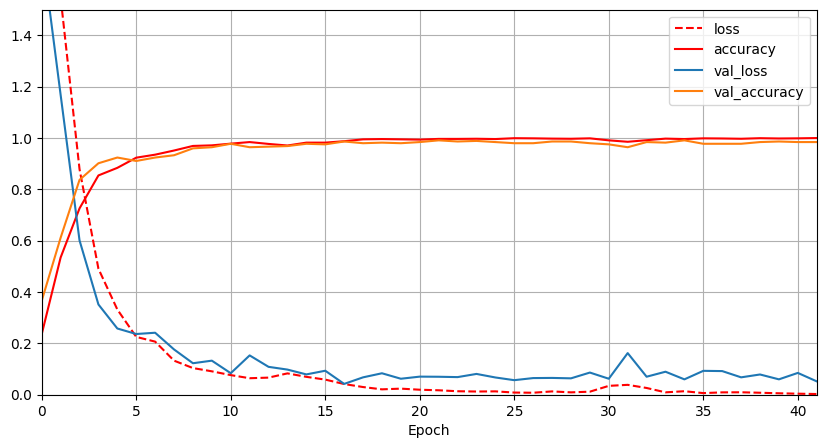

*********TEST**********
Nº de muestras para el test: (400, 40, 40, 3)
Resultados del test:

Test accuracy: 0.9950000047683716
Test loss: 0.029318852350115776
13/13 [==============================] - 0s 3ms/step


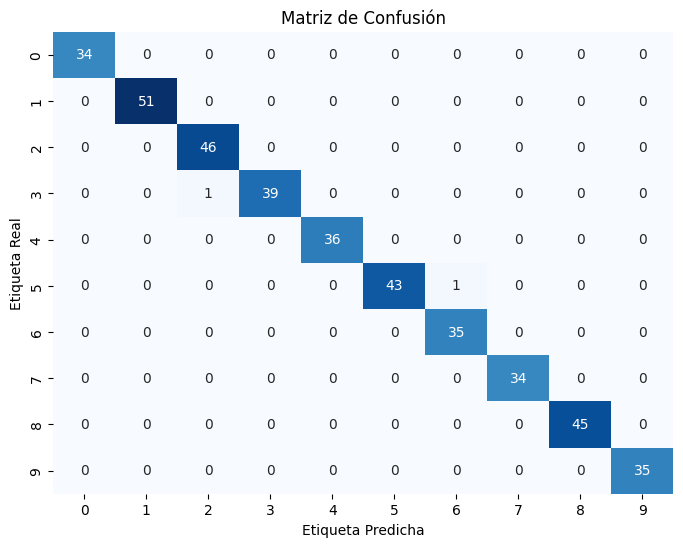

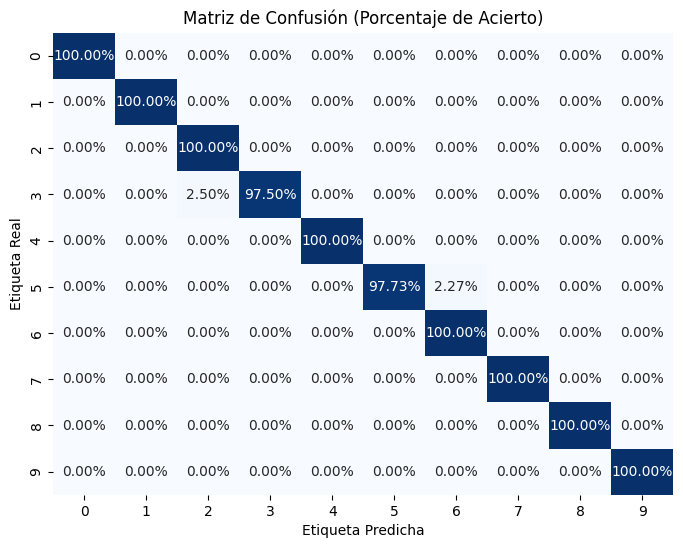

In [ ]:
x_train =np.load(f'{ruta}/x_train_Fourierv2.npy')
y_train =np.load(f'{ruta}/y_train_Fourierv2.npy')

x_test = np.load(f'{ruta}/x_test_Fourierv2.npy')
y_test = np.load(f'{ruta}/y_test_Fourierv2.npy')

entrenamiento(x_train, y_train, x_test, y_test, 400, 20)

## originalv2 Desbalanceado 50

x_train_3D matriz = (650, 40, 40, 3)
x_test_3D matriz = (560, 40, 40, 3)
x_train = (520, 40, 40, 3)
x_train_val = (130, 40, 40, 3)
Epoch 1/200
5/5 [==============================] - 3s 168ms/step - loss: 33.5836 - accuracy: 0.1058 - val_loss: 4.1234 - val_accuracy: 0.5692
Epoch 2/200
5/5 [==============================] - 0s 44ms/step - loss: 3.9309 - accuracy: 0.5000 - val_loss: 1.6882 - val_accuracy: 0.5769
Epoch 3/200
5/5 [==============================] - 0s 33ms/step - loss: 1.6786 - accuracy: 0.5654 - val_loss: 1.1931 - val_accuracy: 0.6615
Epoch 4/200
5/5 [==============================] - 0s 39ms/step - loss: 1.1122 - accuracy: 0.6692 - val_loss: 0.8959 - val_accuracy: 0.7154
Epoch 5/200
5/5 [==============================] - 0s 39ms/step - loss: 0.7304 - accuracy: 0.7654 - val_loss: 0.6104 - val_accuracy: 0.8308
Epoch 6/200
5/5 [==============================] - 0s 37ms/step - loss: 0.5151 - accuracy: 0.8346 - val_loss: 0.4622 - val_accuracy: 0.8692
Epoch 7/200
5/5 [==========

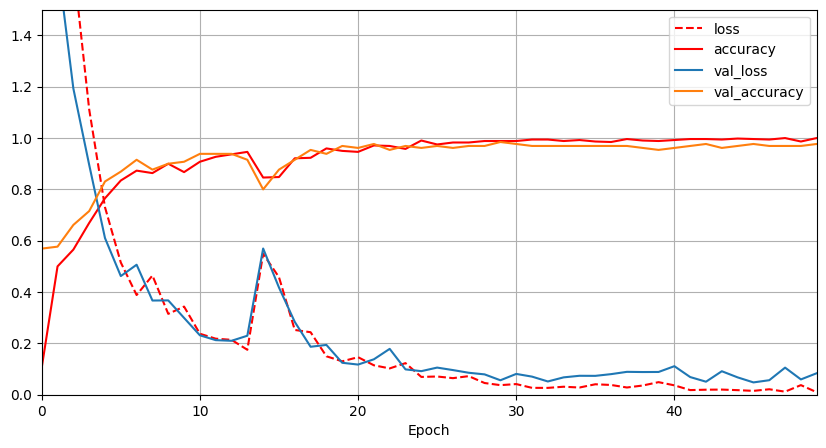

*********TEST**********
Nº de muestras para el test: (400, 40, 40, 3)
Resultados del test:

Test accuracy: 0.9574999809265137
Test loss: 0.1510974019765854
13/13 [==============================] - 0s 2ms/step


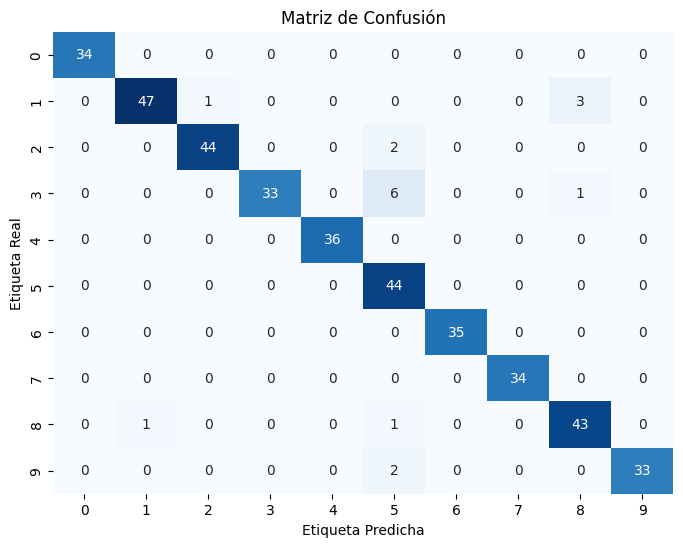

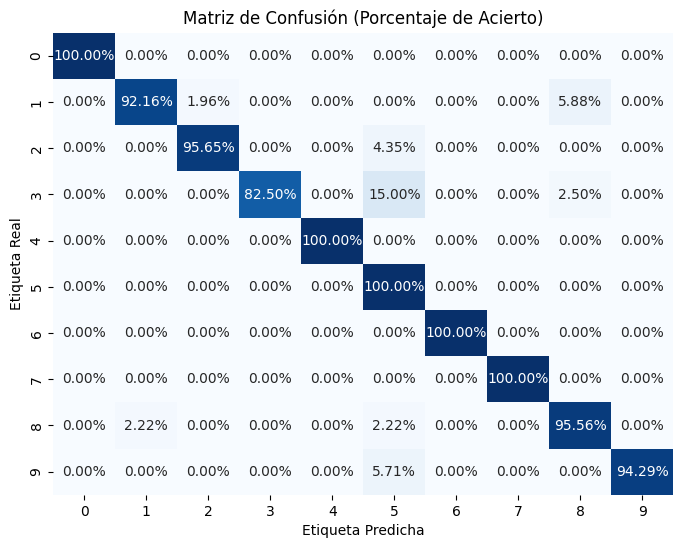

In [ ]:
x_train =np.load(f'{ruta}/x_train_Fourierv2_desbalanceado50.npy')
y_train =np.load(f'{ruta}/y_train_Fourierv2_desbalanceado50.npy')

x_test = np.load(f'{ruta}/x_test_Fourierv2.npy')
y_test = np.load(f'{ruta}/y_test_Fourierv2.npy')

entrenamiento(x_train, y_train, x_test, y_test, 400, 20)

## Originalv2 DATASET DCGAN

x_train_3D matriz = (2000, 40, 40, 3)
x_test_3D matriz = (560, 40, 40, 3)
x_train = (1600, 40, 40, 3)
x_train_val = (400, 40, 40, 3)
Epoch 1/200
13/13 [==============================] - 2s 32ms/step - loss: 11.8420 - accuracy: 0.3094 - val_loss: 1.2539 - val_accuracy: 0.6400
Epoch 2/200
13/13 [==============================] - 0s 18ms/step - loss: 0.8546 - accuracy: 0.8019 - val_loss: 0.3629 - val_accuracy: 0.9350
Epoch 3/200
13/13 [==============================] - 0s 19ms/step - loss: 0.2779 - accuracy: 0.9312 - val_loss: 0.1662 - val_accuracy: 0.9525
Epoch 4/200
13/13 [==============================] - 0s 18ms/step - loss: 0.1698 - accuracy: 0.9481 - val_loss: 0.1145 - val_accuracy: 0.9625
Epoch 5/200
13/13 [==============================] - 0s 14ms/step - loss: 0.1295 - accuracy: 0.9594 - val_loss: 0.1091 - val_accuracy: 0.9625
Epoch 6/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0899 - accuracy: 0.9681 - val_loss: 0.0823 - val_accuracy: 0.9575
Epoch 7/200
13

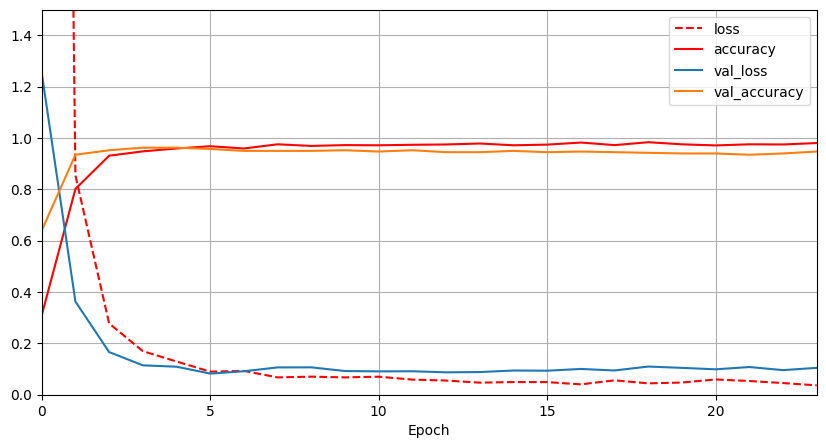

*********TEST**********
Nº de muestras para el test: (400, 40, 40, 3)
Resultados del test:

Test accuracy: 0.8725000023841858
Test loss: 0.4600023031234741
13/13 [==============================] - 0s 2ms/step


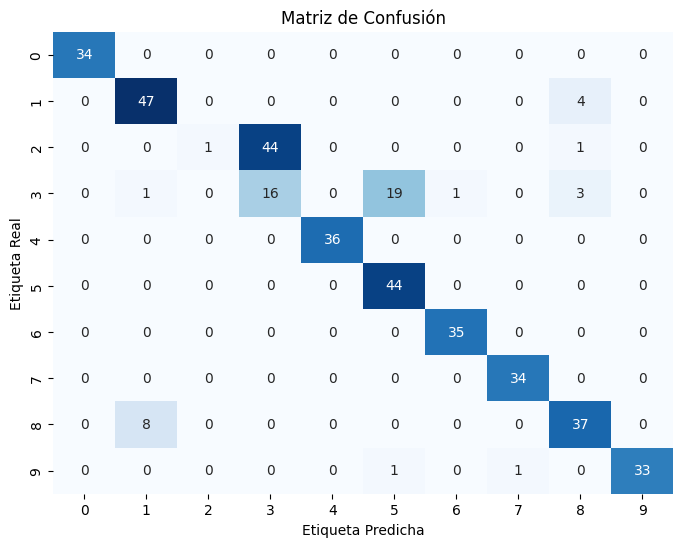

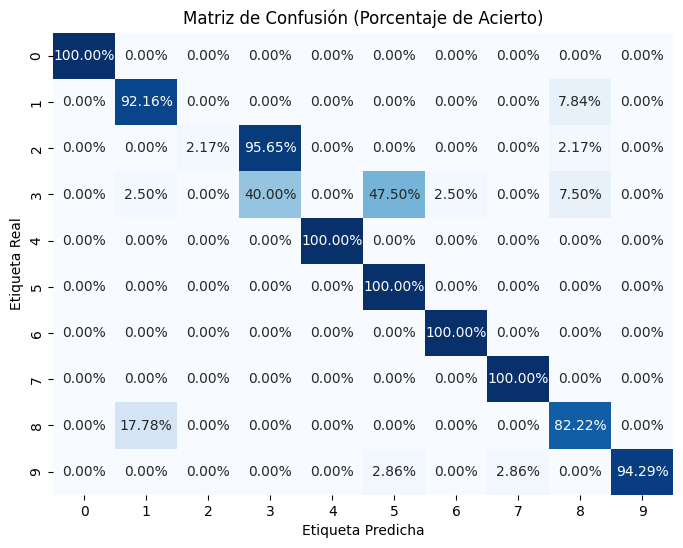

In [ ]:
x_train =np.load(f'{ruta}/x_train_generado_150.npy')
y_train =np.load(f'{ruta}/y_train_generado_150.npy')

x_test = np.load(f'{ruta}/x_test_Fourierv2.npy')
y_test = np.load(f'{ruta}/y_test_Fourierv2.npy')

entrenamiento(x_train, y_train, x_test, y_test, 400, 20)